---

# Importing Libraries

In [3]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=17732b586d6188d2f29a873b82f20e8bea135e01ba56cd24ad50b82ffc307d95
  Stored in directory: /root/.cache/pip/wheels/35/e4/69/cb99d996d14a2971b79b990d68b05a17d58ce530ff96090dfc
Successfully built imutils


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/code-to-cure/metaData.csv
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_0789.jpg
/kaggle/input/code-to-cure/Training/pituitary/Tr-pi_1445.jpg
/kaggle/input/code-to-cure/Training/pituitary

In [4]:
import imutils
from tensorflow.keras.applications.vgg19 import preprocess_input

---

---

# Data Preperation

In [5]:
labels = ['glioma','meningioma','notumor','pituitary']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [6]:
def preprocess_image(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        return np.array(new_img)


In [7]:
import os
X_train = []
y_train = []
image_size = 224
path="/kaggle/input/code-to-cure/Training"
labels = os.listdir(path)
for label in labels:
    for image in tqdm(os.listdir(path + "/"+ label)):
        impath=os.path.join(path + "/" +label,image)
#         img = cv2.imread(os.path.join(path + "/" +label,image))
#         print(os.path.join(path + "/" +label,image))
        img=preprocess_image(impath)
        img=preprocess_input(img)
       
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(label)


        

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1217/1217 [00:09<00:00, 123.02it/s]


In [8]:
original=y_train.copy()
y_train=[]
for i in original:
    if i == "glioma":
        y_train.append([1., 0., 0., 0.])
    elif i == "meningioma":
        y_train.append([0., 1., 0., 0.])
    elif i == "notumor":
        y_train.append([0., 0., 1., 0.])
    else:
        y_train.append([0., 0., 0., 1.])
y_train=np.array(y_train)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,

    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)
# Load your X_train data as an array

# Fit the data generator on your data
datagen.fit(X_train)

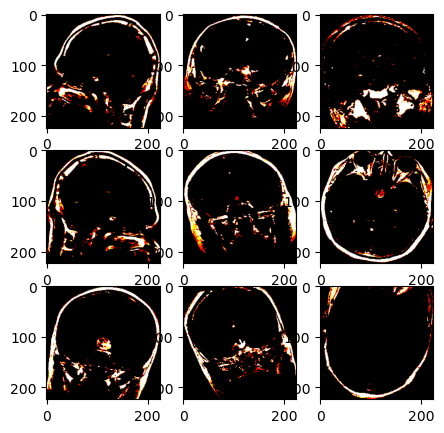

In [10]:
# plot some images from X_train_pre
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i], cmap='gray')
plt.show()

In [11]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

Dividing the dataset into **Training** and **Testing** sets.

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [12]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 1s 0us/step


**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [13]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [14]:
opt = tf.keras.optimizers.Adam(lr=0.001)

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = opt, metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [16]:
X_train.shape

(5229, 224, 224, 3)

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=5,          # number of epochs to wait before stopping
    verbose=1            # print a message when training stops early
)

# checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.0001,
                              mode='auto',verbose=1)

---

# Training The Model

In [19]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[reduce_lr,early_stop])

Epoch 1/10


2023-05-25 19:38:44.723546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


148/148 [==============================] - 79s 231ms/step - loss: 0.2920 - accuracy: 0.9014 - val_loss: 0.2958 - val_accuracy: 0.9044 - lr: 0.0010
Epoch 2/10
148/148 [==============================] - 32s 217ms/step - loss: 0.1339 - accuracy: 0.9560 - val_loss: 0.1996 - val_accuracy: 0.9426 - lr: 0.0010
Epoch 3/10
148/148 [==============================] - 32s 216ms/step - loss: 0.0774 - accuracy: 0.9754 - val_loss: 0.2277 - val_accuracy: 0.9465 - lr: 0.0010
Epoch 4/10
148/148 [==============================] - 33s 220ms/step - loss: 0.1122 - accuracy: 0.9645 - val_loss: 0.2334 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 5/10
148/148 [==============================] - 32s 217ms/step - loss: 0.1247 - accuracy: 0.9590 - val_loss: 0.3277 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 6/10
148/148 [==============================] - 32s 217ms/step - loss: 0.0488 - accuracy: 0.9856 - val_loss: 0.1685 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 7/10
 89/148 [=================>............] - ETA: 12s 

KeyboardInterrupt: 

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [ ]:
def read_data_test(path,image_size = 224):
    X = []
    for image in tqdm(os.listdir(path)):
            impath=os.path.join(path + "/" +image)
            img=preprocess_image(impath)
            img=preprocess_input(img)
       
            img = cv2.resize(img,(image_size, image_size))
            X.append(img)
    return np.array(X)

In [ ]:
test_dir = '/kaggle/input/code-to-cure/Testing'
test=read_data_test(test_dir)

In [ ]:
import os
image_filenames = os.listdir('/kaggle/input/code-to-cure/Testing')
image_ids = [int(filename.split('.')[0]) for filename in image_filenames]
import pandas as pd

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred,axis=1)

In [ ]:
#submission_df = pd.DataFrame({'ID': image_ids, 'Label': pred})


In [ ]:
#submission_df.Label.value_counts()

In [ ]:
#submission_df.to_csv('submission.csv', index=False)

---